# Scatter Plots

## Load Libraries

In [70]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [71]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [72]:
## ---------------------------------------

name0 = "FFBI"

name1 = "ROMY_U"
name2 = "ROMY_V"
name3 = "ROMY_Z"

# t1 ,t2 = "2023-09-23", "2023-10-23"

In [73]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"

## Methods

In [74]:
dat1 = pd.read_pickle(config['path_to_data']+name0+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")

In [75]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)    

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [76]:
def __quantile_regression(x, y, quantiles=[0.05, 0.5, 0.95]):


    from sklearn.utils.fixes import parse_version, sp_version
    from sklearn.linear_model import QuantileRegressor
    from numpy import newaxis, zeros_like, bool_, logical_or, array

    # This is line is to avoid incompatibility if older SciPy version.
    # You should use `solver="highs"` with recent version of SciPy.
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

    predictions = {}

    x = array(x)
    X = x[:, newaxis]

    out_bounds_predictions = zeros_like(y, dtype=bool_)

    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

        if quantile == min(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred >= y
            )
        elif quantile == max(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred <= y
            )

    print(qr.score(X, y))
    return predictions

In [77]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat1.shape[1] - 1

bands = dat1.keys()[1:]

for _n, band in enumerate(bands):

    if not _n == 10:
        continue

    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]

    _df = pd.merge(left=_dat1, right=_dat2, how="inner", on="dates")

    _df.dropna(inplace=True)

    _df = _df[_df.iloc[:, 1] < 1e-15]
    _df = _df.reset_index(drop=True)


    xx = np.log10(_df.iloc[:, 1])
    yy = np.log10(_df.iloc[:, 2])

    try:
        pre = __quantile_regression(xx, yy, quantiles=[0.1, 0.5, 0.9])

    except:
        continue

    if not _df.empty:

        fig = plt.figure()

        # ys = powerfit(xx, pre, xx)
        # plt.plot(xx, ys, color="tab:green", ls="--")

        # plt.scatter(_df[f'{band}_x'], _df[f'{band}_y'], s=15, edgecolors="black", lw=0.5, zorder=2)
        plt.scatter(10**xx, 10**yy, s=15, edgecolors="black", lw=0.5, zorder=2)

        plt.plot(10**xx, 10**pre[0.9], color="k", zorder=1, ls=":")

        plt.xscale("log")
        plt.yscale("log")

        plt.title(f"{name1.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df.keys()[1][:-2])*1e3} mHz")
        plt.ylabel(r"PSD (hPa$^2$ /Hz)")
        plt.xlabel(r"PSD (rad$^2$ /s$^2$ /Hz)")
        plt.grid(zorder=0, alpha=0.5)

        plt.ylim(1e-7, 1e1)
        plt.xlim(1e-23, 1e-15)

        plt.show();

        fig.savefig(config['path_to_figs']+f"{name1}/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz.png", format="png", dpi=200, bbox_inches='tight');

## Plot all 

In [78]:
dat0 = pd.read_pickle(config['path_to_data']+name0+".pkl")

dat1 = pd.read_pickle(config['path_to_data']+name1+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")
dat3 = pd.read_pickle(config['path_to_data']+name3+".pkl")

In [79]:
dat0

dates         0.001       0.00125       0.0016        0.002  \
0    20230923_00   6443.877887   2168.866846   167.992228   361.573504   
1    20230923_01    319.919130   1072.641326  2980.912219  1876.380213   
2    20230923_02  18546.841852   3089.682849   216.630690   474.679137   
3    20230923_03   3894.694233   2006.999077  2698.897208   411.529631   
4    20230923_04   5317.133141    918.099808  1916.218404   585.243580   
..           ...           ...           ...          ...          ...   
739  20231023_19   7656.514478     95.918874  1674.402839   496.581056   
740  20231023_20    176.482748    557.652641     9.162208  1646.221831   
741  20231023_21   1884.593207    155.969656  1482.072870  3570.090953   
742  20231023_22  14911.863094  14267.337312  3123.736994  1393.206545   
743  20231023_23   3356.132586   4378.211201   336.448150  2307.629142   

          0.0025      0.00315        0.004        0.005      0.0063  ...  \
0     549.559834   154.085247    63.835702    16.193525    6.867545  ...   
1    1744.373753   679.802563    39.028299    15.484211    6.144950  ...   
2     287.786792    18.122618    14.049711    15.188621    9.403360  ...   
3      86.416880    47.639094    16.293131    74.604977   14.658536  ...   
4      83.635362   297.941034    58.518730    41.488813   32.254197  ...   
..           ...          ...          ...          ...         ...  ...   
739   214.180107  1397.283011    44.248688    31.693631   21.570228  ...   
740   508.154383   722.549089   937.030894   261.868219   36.482818  ...   
741  3810.267792   427.179497  1244.186397  2061.707455  225.156819  ...   
742   444.767162   639.821561   304.724912    28.000038   35.561300  ...   
743   530.594623   905.990800   694.349749   588.163259  280.531762  ...   

        0.125      0.16       0.2      0.25     0.315       0.4       0.5  \
0    0.538210  0.349034  0.290505  0.268999  0.188595  0.135952  0.099171   
1    0.214857  0.180158  0.099452  0.081160  0.054204  0.042752  0.027609   
2    0.225043  0.129748  0.094777  0.095421  0.064622  0.039296  0.028158   
3    0.356514  0.239544  0.162826  0.128108  0.082348  0.071168  0.058920   
4    0.779141  0.324589  0.216810  0.233945  0.113717  0.096830  0.085365   
..        ...       ...       ...       ...       ...       ...       ...   
739  0.064104  0.041039  0.035498  0.019267  0.016058  0.007967  0.007075   
740  0.017595  0.017051  0.012469  0.010687  0.006579  0.005116  0.004146   
741  0.006908  0.005703  0.009360  0.006111  0.004669  0.003652  0.003605   
742  0.006787  0.008113  0.007493  0.005483  0.005512  0.003792  0.003614   
743  0.007184  0.008497  0.007959  0.006885  0.004484  0.003919  0.003916   

         0.63       0.8       1.0  
0    0.066381  0.035520  0.025664  
1    0.017455  0.011264  0.008088  
2    0.017091  0.011536  0.008183  
3    0.038425  0.024885  0.017172  
4    0.060267  0.033692  0.022474  
..        ...       ...       ...  
739  0.005865  0.004885  0.004051  
740  0.003762  0.003407  0.003147  
741  0.003148  0.003077  0.003119  
742  0.003630  0.003464  0.003088  
743  0.003132  0.003069  0.003039  

[744 rows x 32 columns]

-1.2425058280935635
-1.0611799584140336
-1.0924245797605283


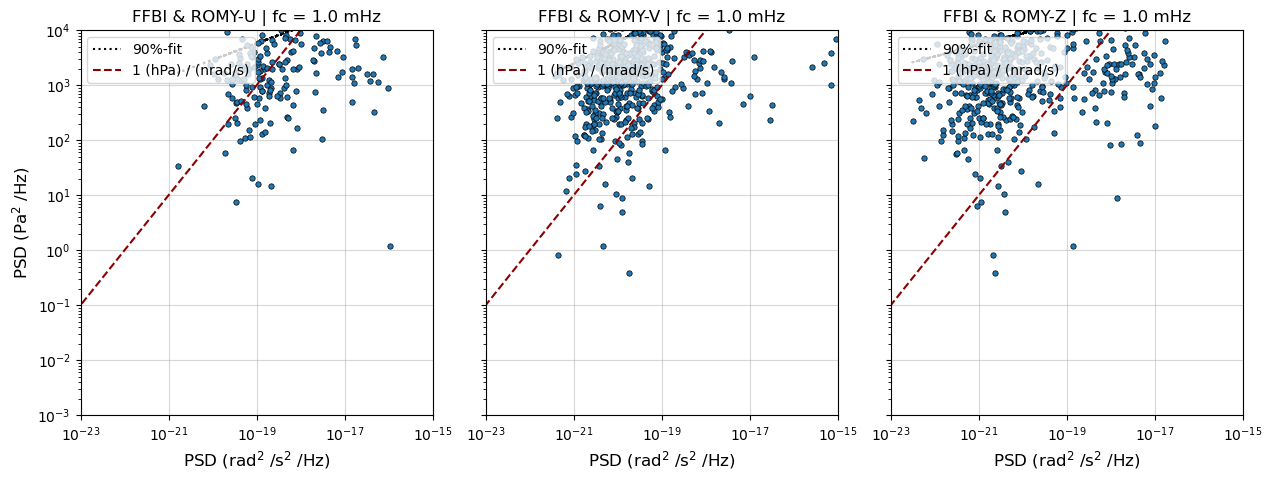

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by QuantileRegressor.
x and y must have same first dimension, but have shapes (0,) and (170,)


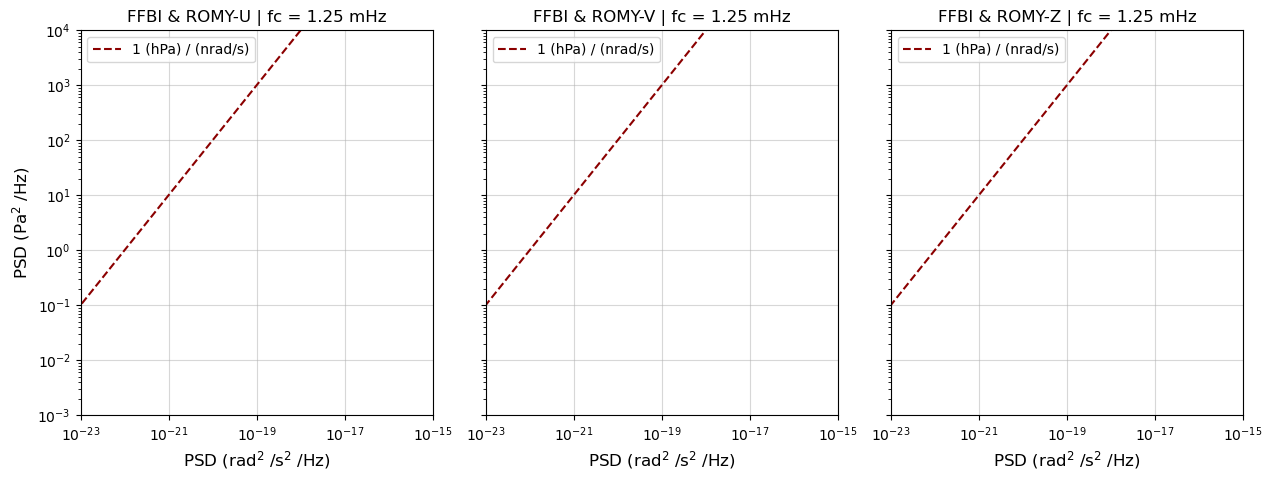

-1.1869895010347191
-1.3705365530442002
-1.2301800864421093


-1.276653811287383
-1.3491070233782878
-1.7842187701324481


-1.611251188567468
-1.2943571072243292
-1.4652782755667557


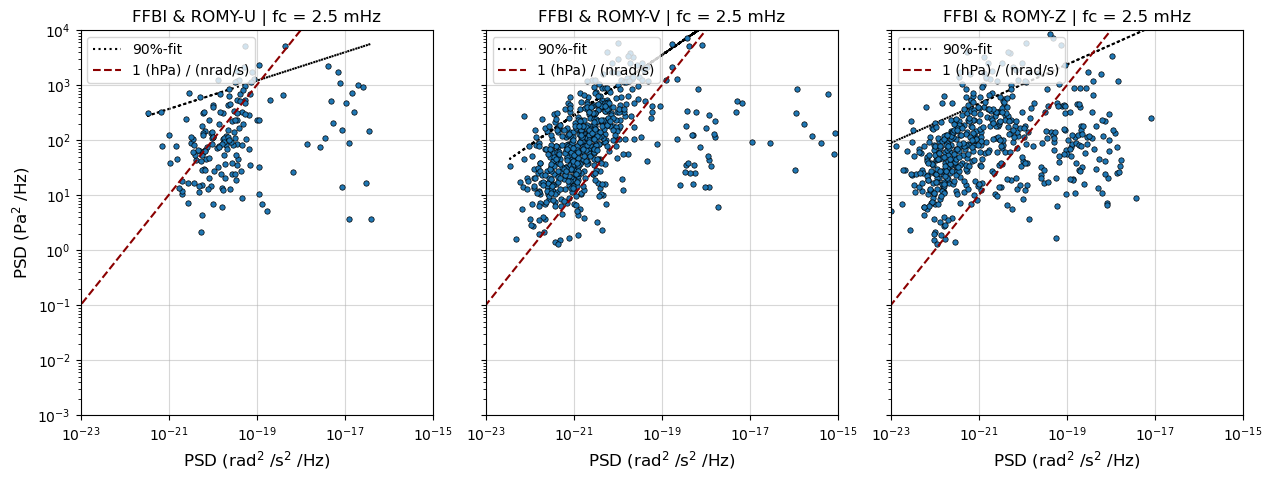

-1.892506899215122
-1.3658142893909515
-1.4841291377719705


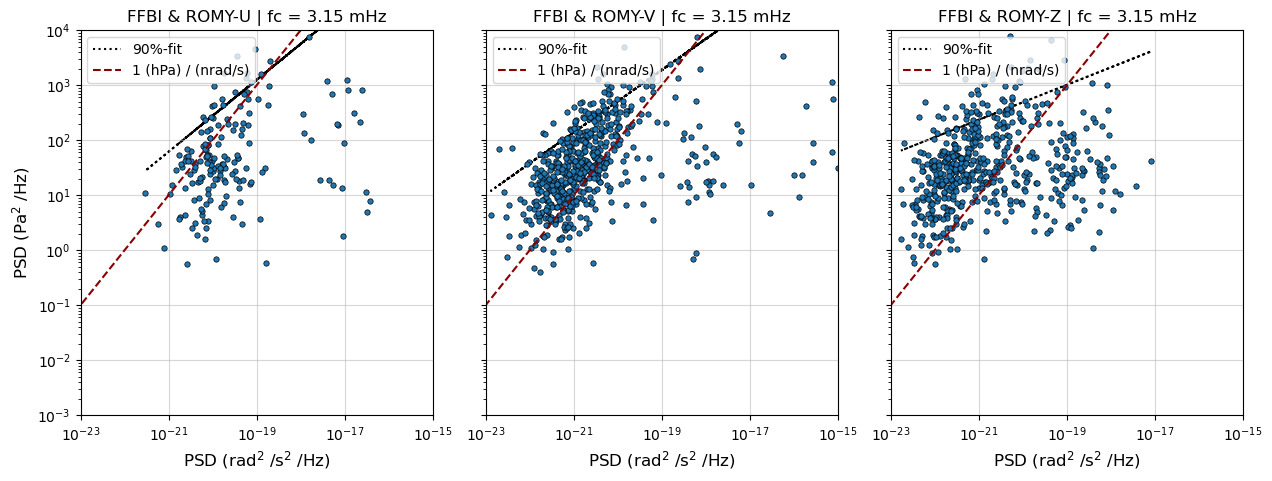

-1.7339997903030713
-1.523267440123317
-1.694957878624486


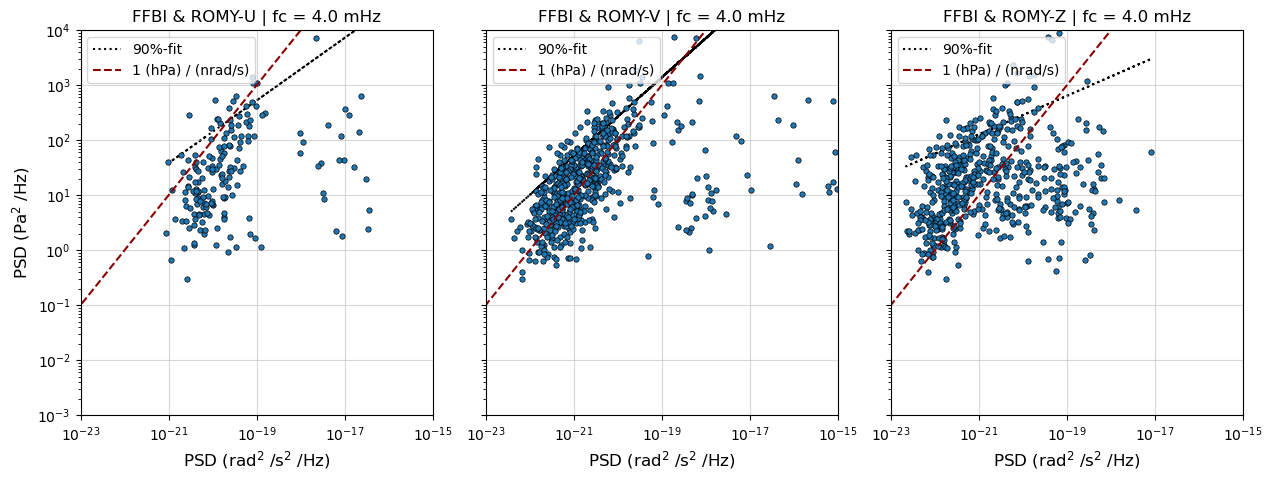

-2.0581118955009954
-1.4671634977490742
-1.796622388613824


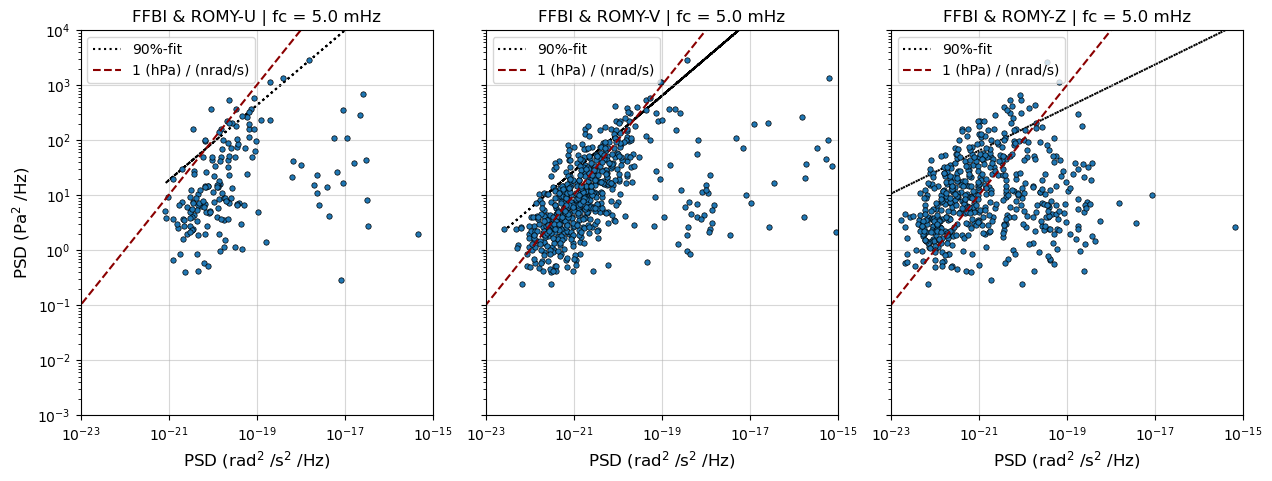

-1.8413537908904383
-1.5378022981245256
-1.9932121771395028


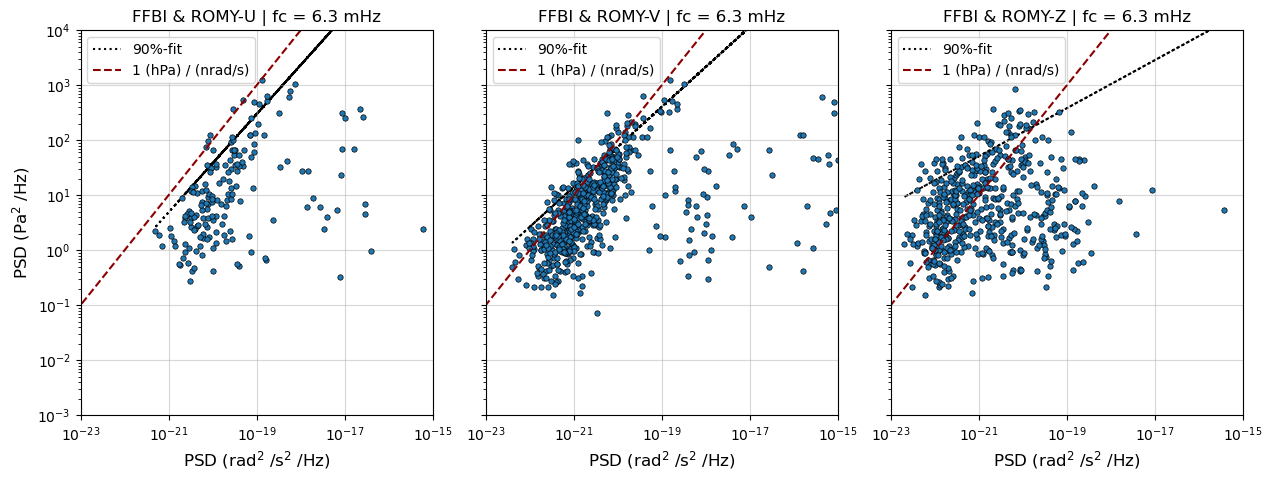

-1.9426085365972634
-1.4830311747609732
-1.9199039154063984


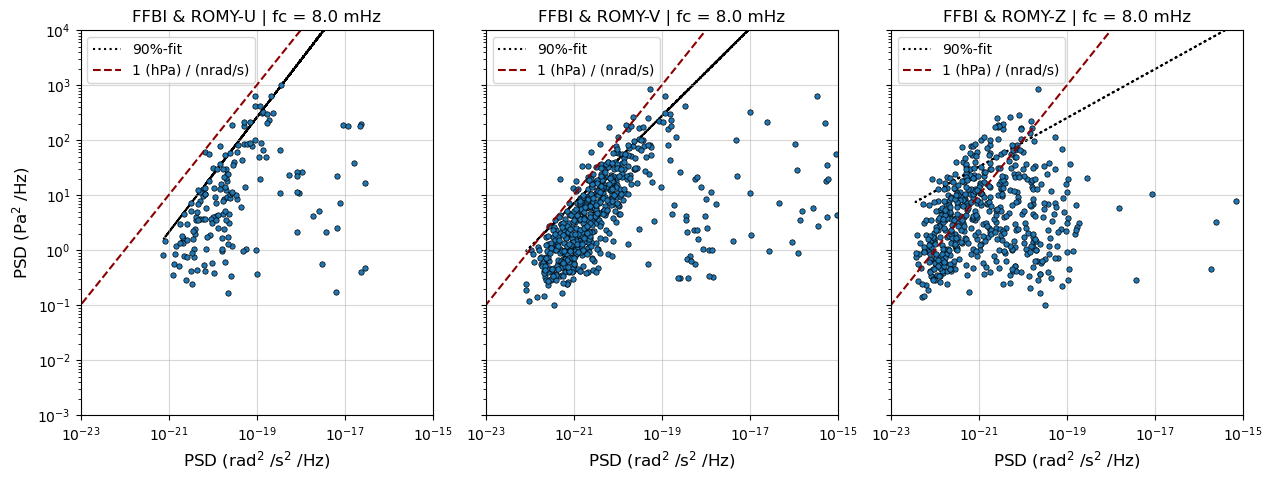

-1.3081005782719397
-1.4905748138183368
-2.0840584884795135


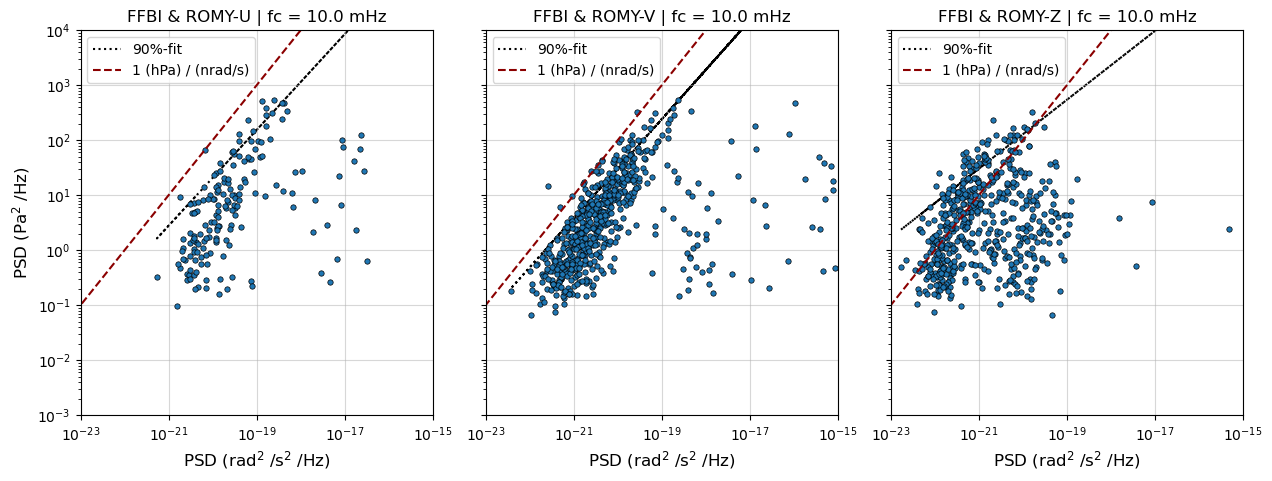

-1.1926334779726457
-1.4098792031511702
-1.7421836842063634


-1.164758017417861
-1.6568591726522741
-1.8868759602841094


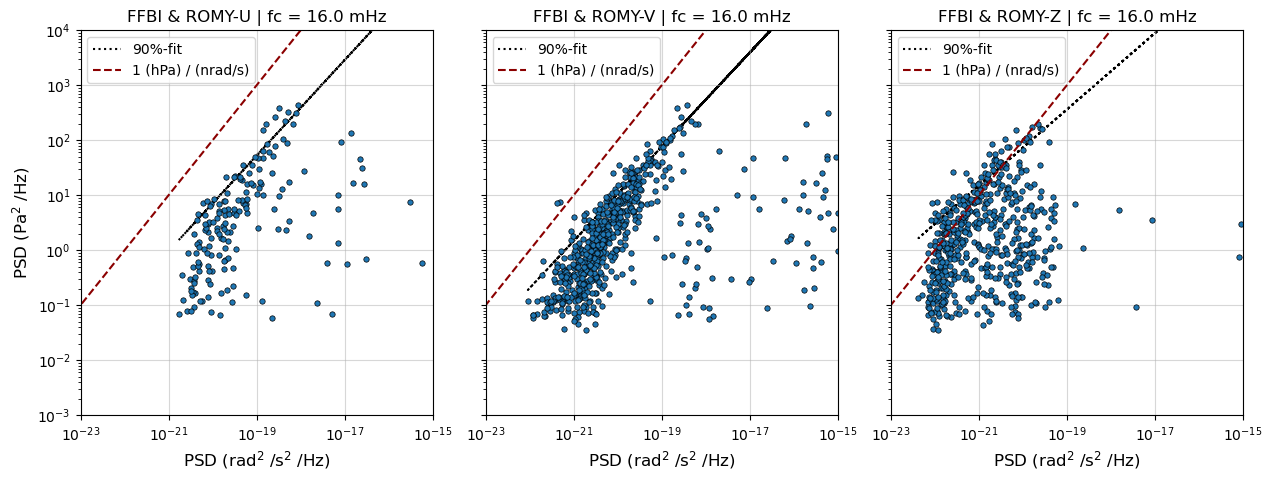

-1.0290629621487493
-1.3189545743847435
-1.7099678988553384


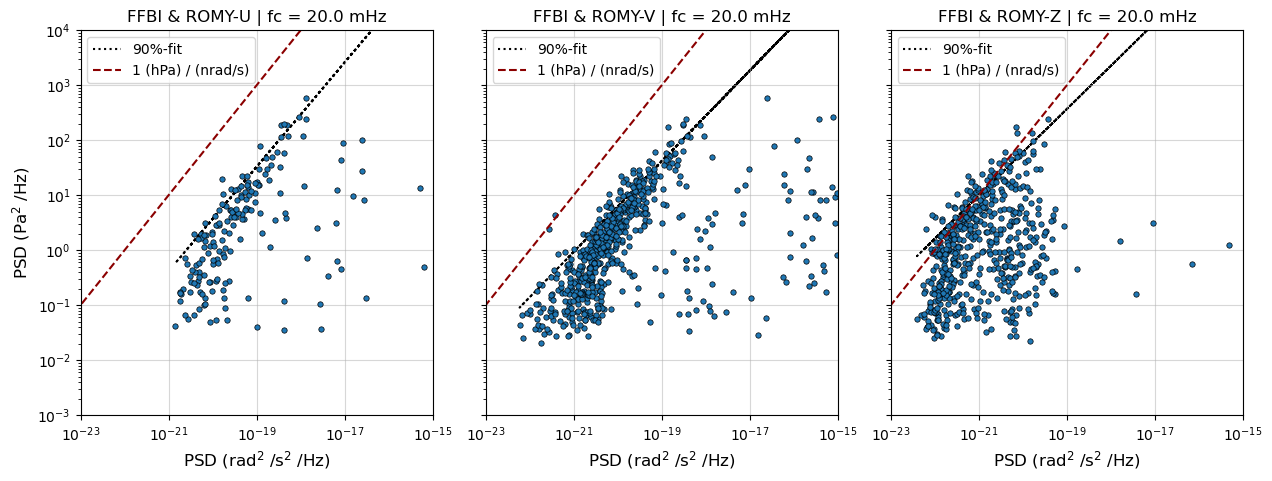

-0.7569602192687057
-1.2205498975466624
-1.5635691960237055


-0.721068171858777
-1.2674096178069956
-1.5758305423049572


-0.6976587028831351
-1.2318072744191162
-1.6273882526751744


-0.6028813455221647
-1.1661638722530974
-1.32755866579891


-0.5369634585384144
-1.063605721638373
-1.2865065218297245


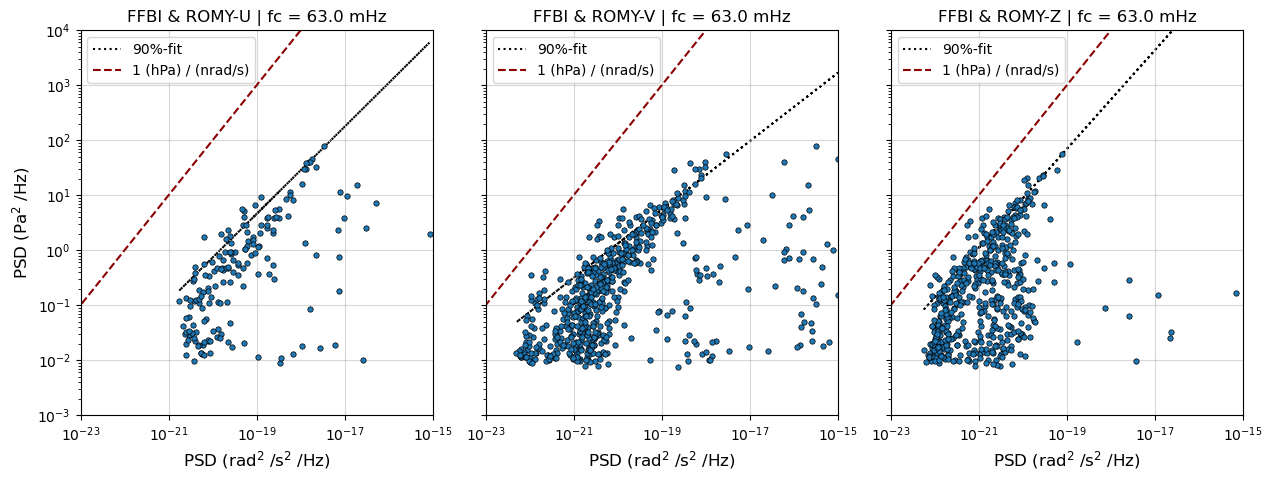

-0.7479197373787663
-1.220705824331234
-1.1344936806087182


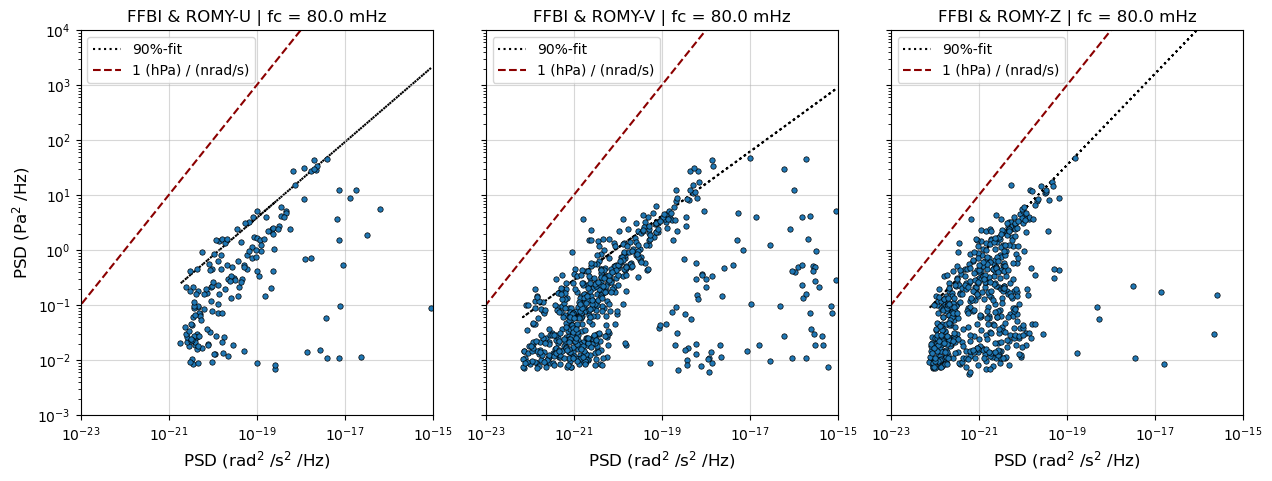

-0.8441613139580708
-1.2772820204000914
-0.9943031303906258


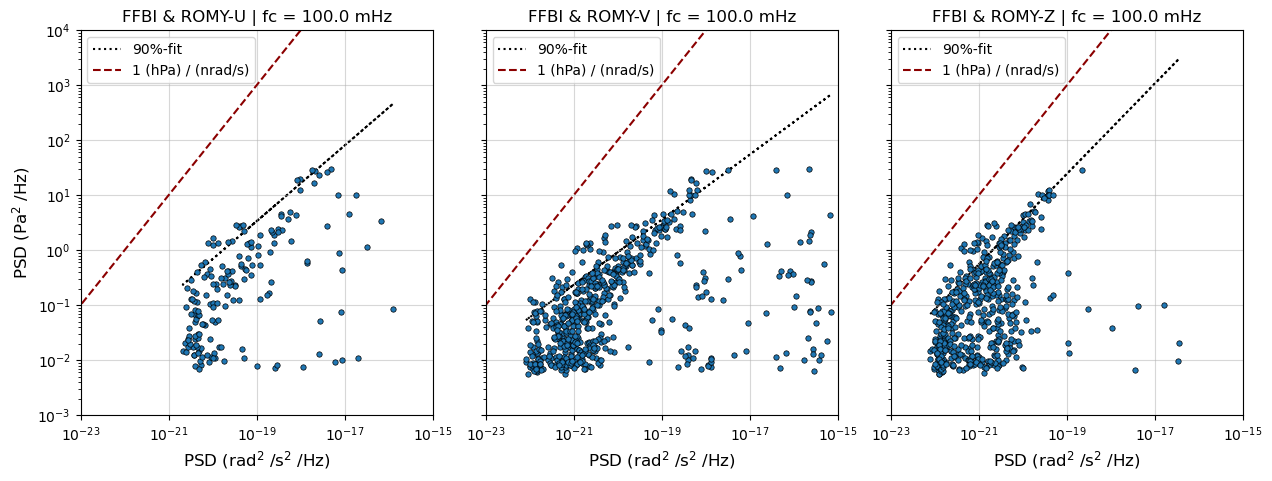

-0.782674380700521
-1.77185061009973
-1.9701537423163424


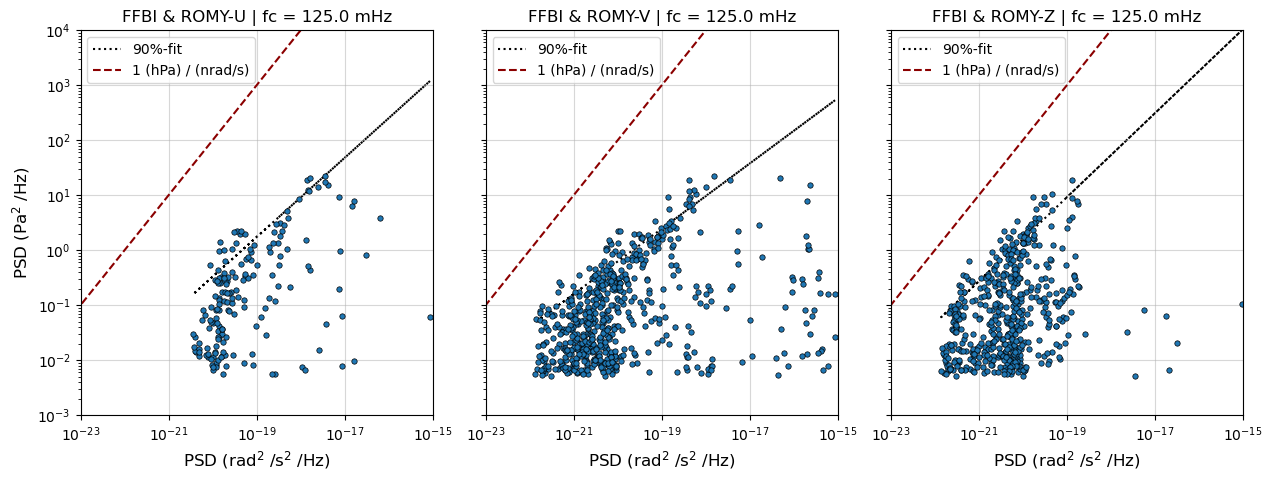

-1.4569175661842144
-2.2660045688633517
-2.150408214437955


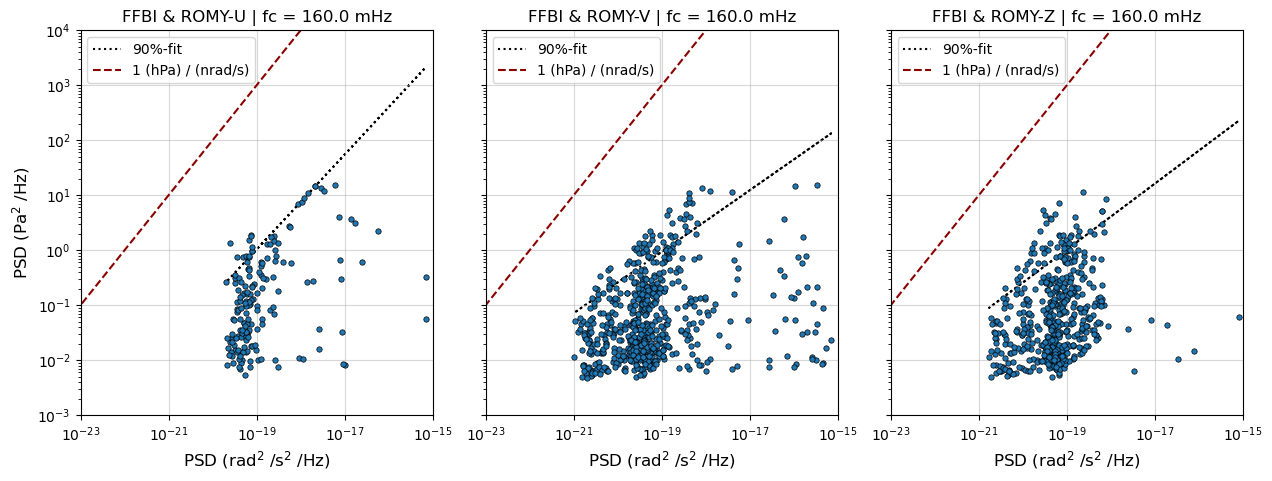

-1.6607897428559504
-2.7198217026255698
-2.35617819264352


-1.6308038133634564
-2.7389247399490664
-2.4692045301928505


-2.2776993817604656
-2.585267512412645
-2.800964034489884


-2.5123014457452055
-2.2508634459144714
-2.7849487475528614


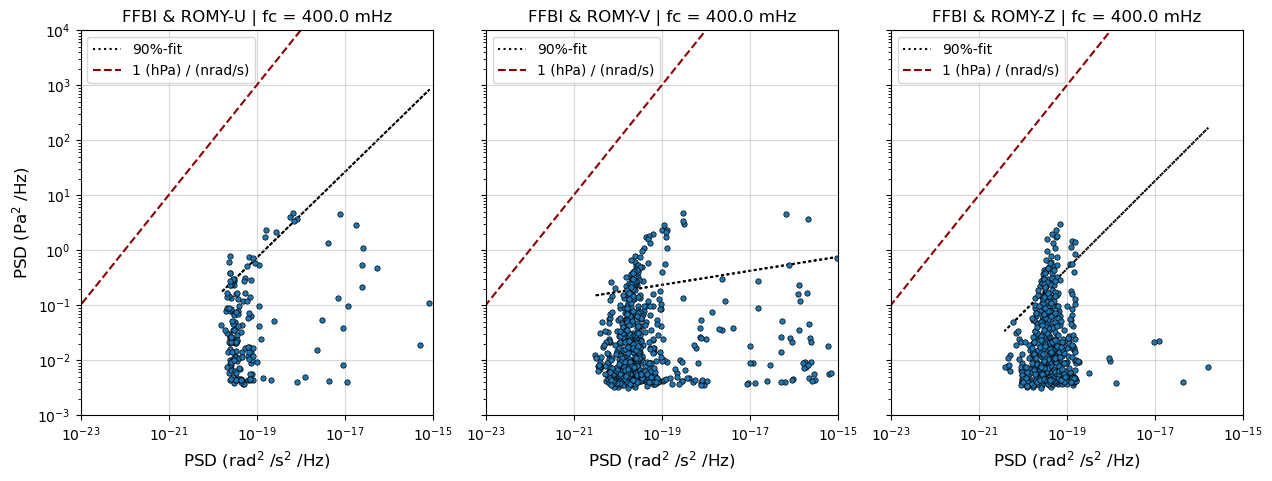

-2.7330796843247778
-2.4886357545896245
-3.1170930774027665


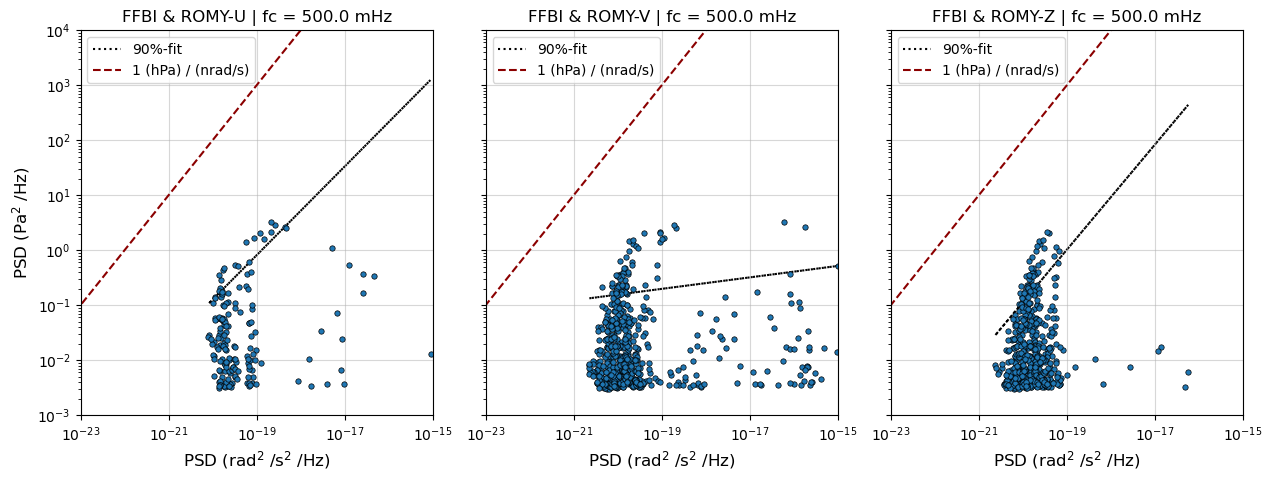

-2.585502242841222
-2.427310984174196
-3.2185202369575023


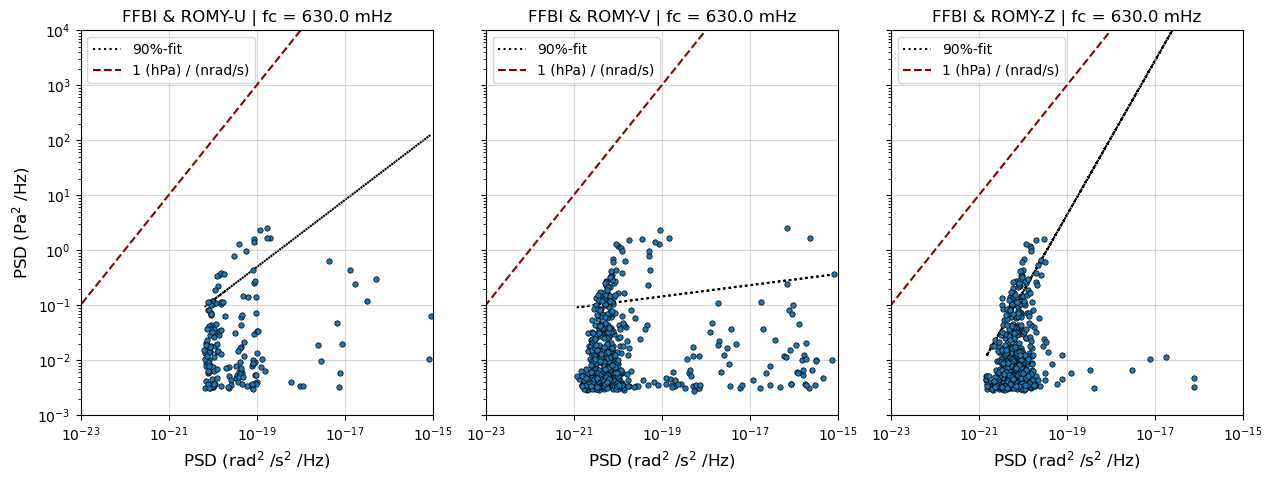

-2.163955129794377
-2.742464859964022
-2.938203979701132


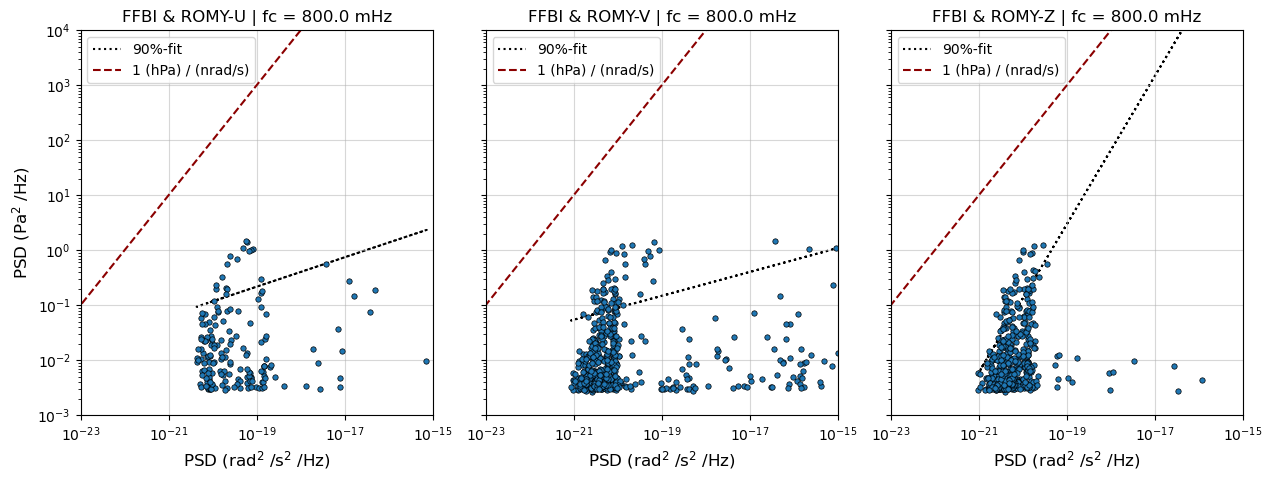

-2.1940350149339927
-2.5778565383857885
-2.691468878704924


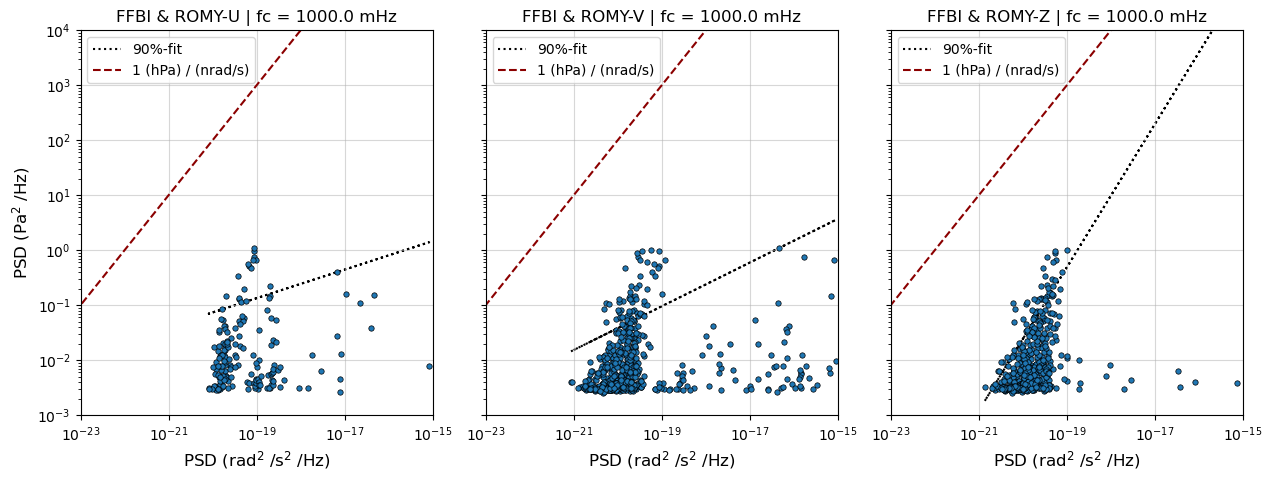

In [105]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat0.shape[1] - 1

bands = dat0.keys()[1:]

for _n, band in enumerate(bands):

    # if not _n == 11:
    #     continue

    _dat0 = dat0.loc[:, ["dates", band]]
    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]
    _dat3 = dat3.loc[:, ["dates", band]]

    ## join data frames based on dates and hour
    _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
    _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
    _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

    # ## remove NaN values
    _df1.dropna(inplace=True)
    _df2.dropna(inplace=True)
    _df3.dropna(inplace=True)

    ## remove large values
    _df1 = _df1[_df1.iloc[:, 2] < 1e-15]
    _df2 = _df2[_df2.iloc[:, 2] < 1e-15]
    _df3 = _df3[_df3.iloc[:, 2] < 1e-15]

    ## reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    xx1, yy1 = np.log10(_df1.iloc[:, 2]), np.log10(_df1.iloc[:, 1])
    xx2, yy2 = np.log10(_df2.iloc[:, 2]), np.log10(_df2.iloc[:, 1])
    xx3, yy3 = np.log10(_df3.iloc[:, 2]), np.log10(_df3.iloc[:, 1])

    try:
        pre1 = __quantile_regression(xx1, yy1, quantiles=[0.1, 0.5, 0.9])
        pre2 = __quantile_regression(xx2, yy2, quantiles=[0.1, 0.5, 0.9])
        pre3 = __quantile_regression(xx3, yy3, quantiles=[0.1, 0.5, 0.9])

    except Exception as e:
        print(e)
        pass


    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.15)

    ax[0].scatter(10**xx1, 10**yy1, s=15, edgecolors="black", lw=0.5, zorder=2)
    ax[1].scatter(10**xx2, 10**yy2, s=15, edgecolors="black", lw=0.5, zorder=2)
    ax[2].scatter(10**xx3, 10**yy3, s=15, edgecolors="black", lw=0.5, zorder=2)

    try:

        ax[0].plot(10**xx1, 10**pre1[0.9], color="k", zorder=1, ls=":", label="90%-fit")
        ax[1].plot(10**xx2, 10**pre2[0.9], color="k", zorder=1, ls=":", label="90%-fit")
        ax[2].plot(10**xx3, 10**pre3[0.9], color="k", zorder=1, ls=":", label="90%-fit")

    except Exception as e:
        print(e)
        pass

    ## add correlation estimate
    _xx = np.logspace(-26, -15)
    _yy = 1e22 * _xx
    # print(_xx, _yy)

    for _i in range(3):
        ax[_i].plot(_xx, _yy, color="darkred", ls="--", label="1 (hPa) / (nrad/s)")


    for _i in range(3):
        ax[_i].set_xscale("log")
        ax[_i].set_yscale("log")
        ax[_i].set_ylim(1e-3, 1e4)
        ax[_i].set_xlim(1e-23, 1e-15)
        ax[_i].grid(zorder=0, alpha=0.5)
        ax[_i].set_xlabel(r"PSD (rad$^2$ /s$^2$ /Hz)", fontsize=font)
        ax[_i].legend(loc=2)

    ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
    ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
    ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")

    ax[0].set_ylabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)


    plt.show();

    fig.savefig(config['path_to_figs']+f"all/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.png", format="png", dpi=200, bbox_inches='tight');

In [102]:
np.sqrt((1e3-1e1)/(1e-19-1e-21)*1e-18) * 1e-4, (1e3-1e1)/(1e-19-1e-21)

(0.01, 1e+22)